### Random Forest is a model that can be used for both regression and classification. Why is it called random forest? Think of it as a tree of decisions that combine together to get a more accurate prediction.

### For instance, say, given an animal dataset with a set of features (has claws, has whiskers, tail length etc.), you want to classify if it's a cat or dog. Using a random forest, the model would start examining these features and infer if it's a cat or doggo.

### RF is regarded as an ensemble learning model, that means it consists of multiple 'weaker' ML models and allows it to achieve better performance. You might think RF is very similar to decision trees, it is, but in RF case, the process is random, where you have no control over which feature to use for inference.

### When do we use RF over DT then?
* In general, RF is less likely to overfit, so use it to avoid overfitting. Bear in mind there is still possibility that it'd overfit due to the hyperparameters.
* RF in general has better accuracy than DT

In [52]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import plotly
import plotly.figure_factory as ff
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [53]:
file_path = "./rf_data/healthcare-dataset-stroke-data.csv"

In [54]:
df = pd.read_csv(file_path)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Notice that the number of samples for bmi is missing quite a few

In [56]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

As suspected, there are approx. 200 missing values for bmi column

In [57]:
# Remove columns with missing BMI, if I have weight, height value, I'd be able to calculate the BMI but 
# in this case I won't be able to
df = df.dropna()
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
5,56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


### 1. Visualization and EDA

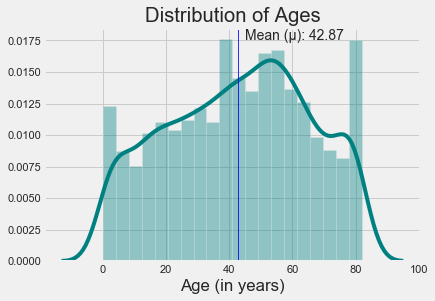

In [58]:
plt.style.use("fivethirtyeight")
sns.distplot(df['age'], color='teal', kde=True)
plt.axvline(df['age'].mean(), color='blue', linestyle='-', linewidth=0.8)
min_ylim, max_ylim = plt.ylim()
plt.text(df['age'].mean()*1.05, max_ylim*0.95, 'Mean (μ): {:.2f}'.format(df['age'].mean()))
plt.xlabel("Age (in years)")
plt.title(f"Distribution of Ages")
plt.show()

Seems like the the age distribution follows a normal distribution, but it is slightly left skewed

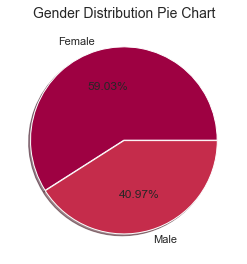

In [59]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 15)]

sns.set(style="whitegrid")
labels = df['gender'].value_counts().index.tolist()[:2]
values = df['gender'].value_counts().tolist()[:2]

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, explode=[0, 0.005], shadow=True)
plt.title("Gender Distribution Pie Chart", fontdict={'fontsize': 14})
plt.show()

Female and male distribution is almost equal

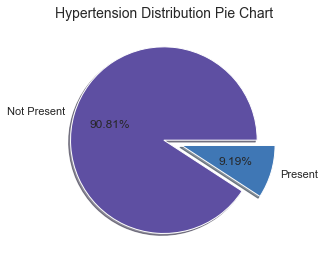

In [60]:
sns.set(style="whitegrid")
labels = ["Not Present", "Present"]
values = df['hypertension'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors[::-1], shadow=True, explode=[0, 0.2])
plt.title("Hypertension Distribution Pie Chart", fontdict={'fontsize': 14})
plt.show()

Seems like the dataset is quite imbalanced, where you have almost 91% of non-hypertension patients

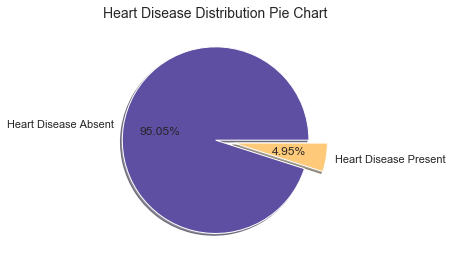

In [61]:
sns.set(style="whitegrid")
random.shuffle(colors)
labels = ["Heart Disease Absent", "Heart Disease Present"]
values = df['heart_disease'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True, explode=[0, 0.2])
plt.title("Heart Disease Distribution Pie Chart", fontdict={'fontsize': 14})
plt.show()

Similar distribution can be observed here as well

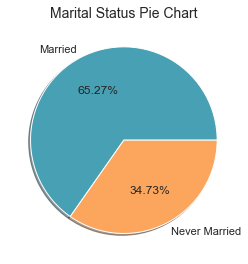

In [62]:
sns.set(style="whitegrid")
random.shuffle(colors)
labels = ["Married", "Never Married"]
values = df['ever_married'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True)
plt.title("Marital Status Pie Chart", fontdict={'fontsize': 14})
plt.show()

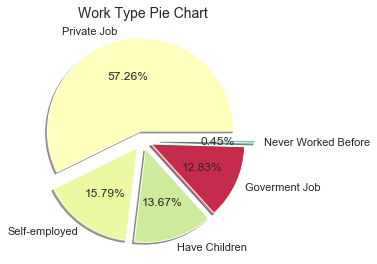

In [63]:
sns.set(style="whitegrid")
random.shuffle(colors)
labels = ["Private Job", "Self-employed", "Have Children", "Goverment Job", "Never Worked Before"]
values = df['work_type'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True, explode=[0.1, 0.1, 0.1, 0.1, 0.2])
plt.title("Work Type Pie Chart", fontdict={'fontsize': 14})
plt.show()

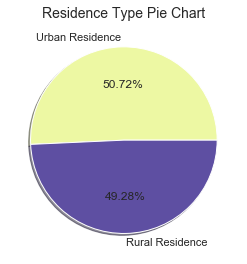

In [64]:
sns.set(style="whitegrid")
random.shuffle(colors)
labels = ["Urban Residence", "Rural Residence"]
values = df['Residence_type'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True)
plt.title("Residence Type Pie Chart", fontdict={'fontsize': 14})
plt.show()

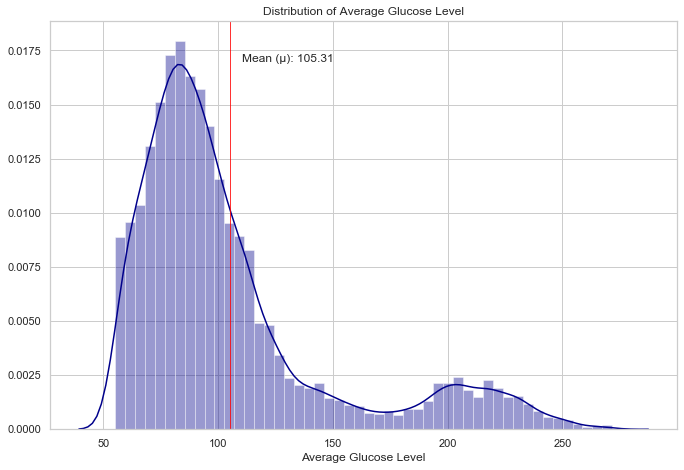

In [65]:
plt.figure(figsize=(10, 7))
sns.distplot(df['avg_glucose_level'], color='darkblue', kde=True)
plt.axvline(df['avg_glucose_level'].mean(), color='red', linestyle='-', linewidth=0.8)
min_ylim, max_ylim = plt.ylim()
plt.text(df['avg_glucose_level'].mean()*1.05, max_ylim*0.9, 'Mean (μ): {:.2f}'.format(df['avg_glucose_level'].mean()))
plt.xlabel("Average Glucose Level")
plt.title(f"Distribution of Average Glucose Level")
plt.show()

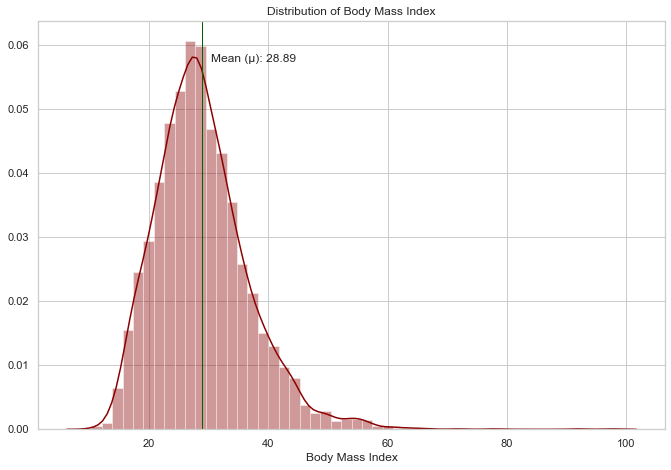

In [66]:
plt.figure(figsize=(10, 7))
sns.distplot(df['bmi'], color='darkred', kde=True)
plt.axvline(df['bmi'].mean(), color='darkgreen', linestyle='-', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(df['bmi'].mean()*1.05, max_ylim*0.9, 'Mean (μ): {:.2f}'.format(df['bmi'].mean()))
plt.xlabel("Body Mass Index")
plt.title(f"Distribution of Body Mass Index")
plt.show()

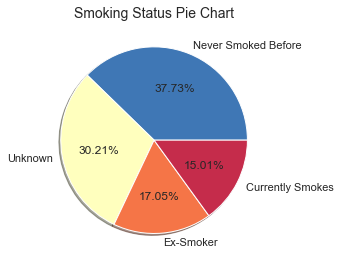

In [67]:
sns.set(style="whitegrid")
random.shuffle(colors)
labels = ["Never Smoked Before", "Unknown", "Ex-Smoker", "Currently Smokes"]
values = df['smoking_status'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True)
plt.title("Smoking Status Pie Chart", fontdict={'fontsize': 14})
plt.show()

I wonder what does Unknown, I am assuming that they don't have any information but I'll keep the columns for now

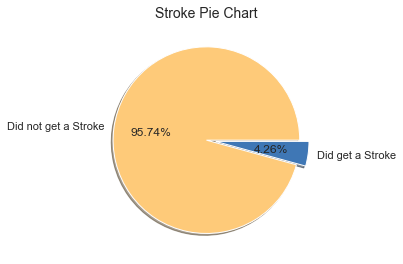

In [68]:
sns.set(style="whitegrid")
random.shuffle(colors)
labels = ["Did not get a Stroke", "Did get a Stroke"]
values = df['stroke'].value_counts().tolist()

plt.pie(x=values, labels=labels, autopct="%1.2f%%", colors=colors, shadow=True, explode=[0, 0.1])
plt.title("Stroke Pie Chart", fontdict={'fontsize': 14})
plt.show()

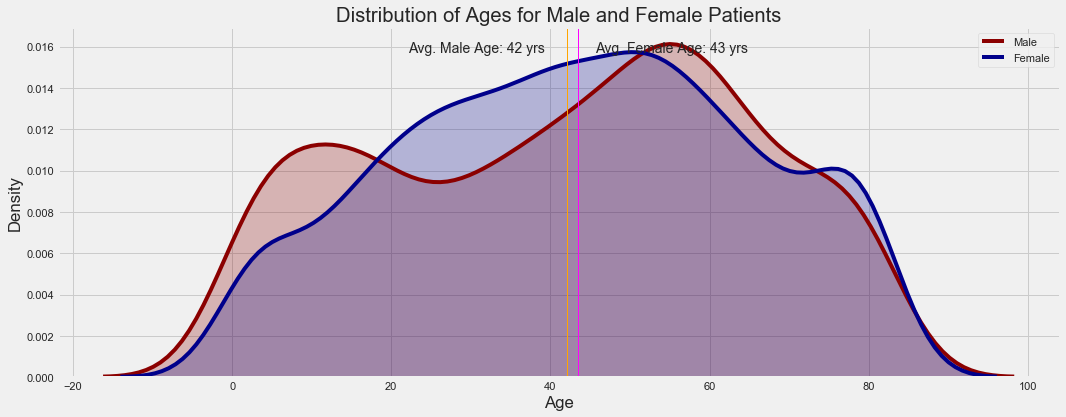

In [69]:
avg_male_age = df[df['gender'] == 'Male']['age'].mean()
avg_female_age = df[df['gender'] == 'Female']['age'].mean()

plt.style.use("fivethirtyeight")
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['gender'] == 'Male', 'age'], label = 'Male', shade=True, color='darkred')
sns.kdeplot(df.loc[df['gender'] == 'Female', 'age'], label = 'Female', shade=True, color='darkblue')

plt.axvline(avg_male_age, color='orange', linestyle='-', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(avg_male_age-20, max_ylim*0.93, 'Avg. Male Age: {} yrs'.format(int(avg_male_age)))

plt.axvline(avg_female_age, color='magenta', linestyle='-', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(avg_female_age*1.05, max_ylim*0.93, 'Avg. Female Age: {} yrs'.format(int(avg_female_age)))

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Ages for Male and Female Patients')
plt.legend()
plt.show()

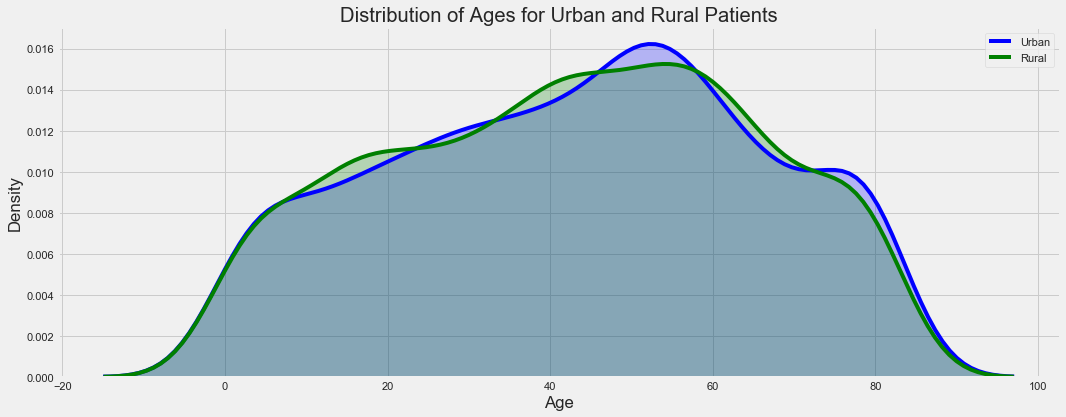

In [70]:
plt.figure(figsize=(16, 6))
sns.kdeplot(df.loc[df['Residence_type'] == 'Urban', 'age'], label = 'Urban', shade=True, color='blue')
sns.kdeplot(df.loc[df['Residence_type'] == 'Rural', 'age'], label = 'Rural', shade=True, color='green')

plt.xlabel('Age')
plt.ylabel('Density')
plt.title('Distribution of Ages for Urban and Rural Patients')
plt.legend()
plt.show()

In [71]:
fig = ff.create_2d_density(
    x=df['age'],
    y=df['avg_glucose_level'],
    title="Age-Average Glucose Level Density Plot",
    colorscale=['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]
)

fig.show()

It seems like older people have a higher average glucose level.

In [72]:
fig = ff.create_2d_density(
    x=df['avg_glucose_level'],
    y=df['bmi'],
    title="Average Glucose Level-BMI Density Plot",
    colorscale=['#7A4579', '#D56073', 'rgb(236,158,105)', (1, 1, 0.2), (0.98,0.98,0.98)]
)

fig.show()

In [73]:
# Binary encoding to map genders
df["gender"] = df["gender"].apply(lambda x: 1 if x=="Male" else 0)

In [74]:
from sklearn.preprocessing import LabelEncoder

df['smoking_status_encoded'] = LabelEncoder().fit_transform(df['smoking_status'])
df[['smoking_status', 'smoking_status_encoded']] # special syntax to get just these two columns



,smoking_status,smoking_status_encoded
0,formerly smoked,1
2,never smoked,2
3,smokes,3
4,never smoked,2
5,formerly smoked,1
...,...,...
5104,Unknown,0
5106,never smoked,2
5107,never smoked,2
5108,formerly smoked,1


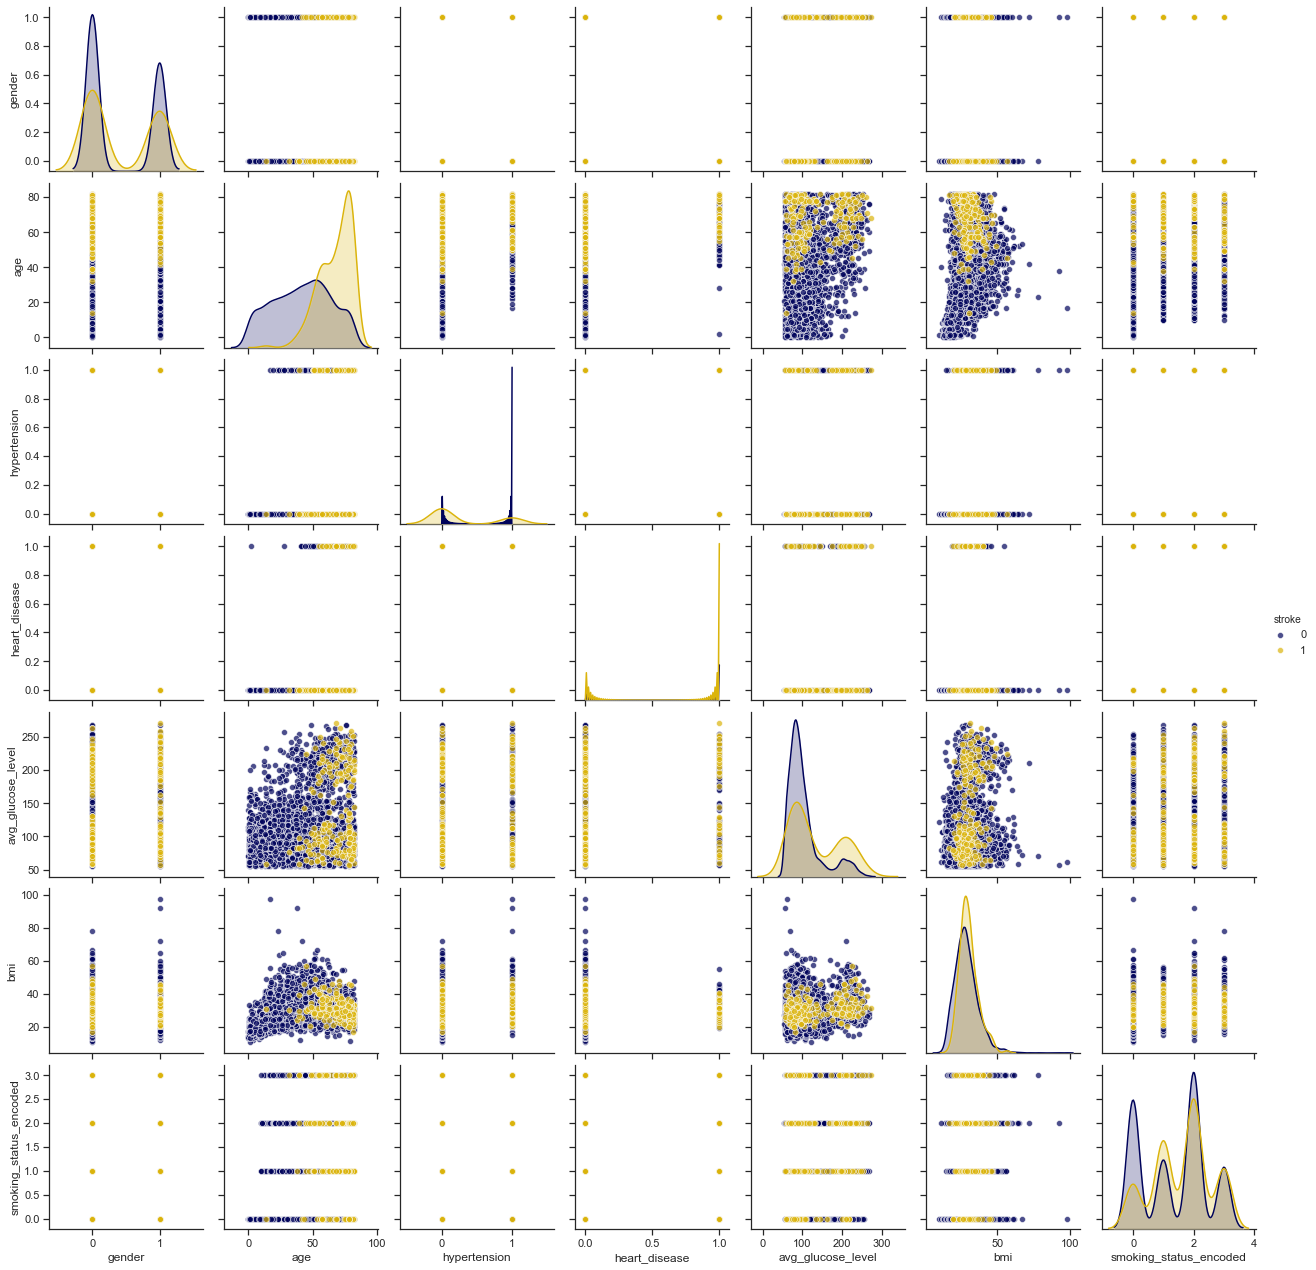

In [76]:
# Will only use six variables for plotting pairs
reduced_features = df[['gender', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status_encoded', 'stroke']]

import seaborn as sns
sns.set(style="ticks", color_codes=True);# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'gold'])# Make the pair plot with a some aesthetic changes
sns.pairplot(reduced_features, hue = 'stroke', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True))

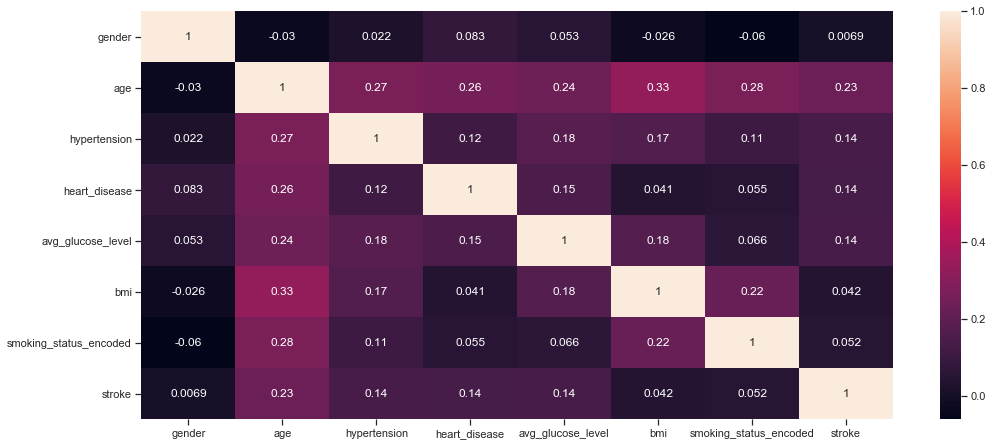

In [77]:
plt.figure(figsize=(15,7))
sns.heatmap(reduced_features.corr(),annot=True);

So, gender, bmi and smoking status does not seem to correlate to stroke, that is a bit weird

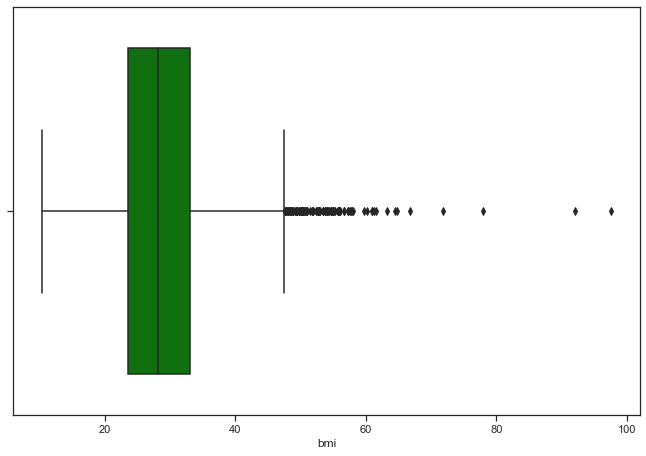

In [78]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df,x=df["bmi"],color='green');

In [79]:
bmi_outliers=df.loc[df['bmi']>50]
bmi_outliers['bmi'].shape

(79,)

In [80]:
df["bmi"] = df["bmi"].apply(lambda x: 50 if x>50 else x)
df["bmi"] = df["bmi"].fillna(28.4)

In [81]:
df["Residence_type"] = df["Residence_type"].apply(lambda x: 1 if x=="Urban" else 0)
df["ever_married"] = df["ever_married"].apply(lambda x: 1 if x=="Yes" else 0)
 
df = pd.get_dummies(data=df, columns=['work_type'])

## 2. Model building

In [82]:
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,smoking_status_encoded,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,1,67.0,0,1,1,1,228.69,36.6,formerly smoked,1,1,0,0,1,0,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,never smoked,1,2,0,0,1,0,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,smokes,1,3,0,0,1,0,0
4,1665,0,79.0,1,0,1,0,174.12,24.0,never smoked,1,2,0,0,0,1,0
5,56669,1,81.0,0,0,1,1,186.21,29.0,formerly smoked,1,1,0,0,1,0,0


In [33]:
# from sklearn.preprocessing import StandardScaler

# # Scaling the variance
# std=StandardScaler()
# columns = ['avg_glucose_level','bmi','age']
# scaled = std.fit_transform(df[['avg_glucose_level','bmi','age']])
# scaled = pd.DataFrame(scaled,columns=columns)
# df=df.drop(columns=columns,axis=1)

In [83]:
# df=df.merge(scaled, left_index=True, right_index=True, how = "left")
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,smoking_status_encoded,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children
0,9046,1,67.0,0,1,1,1,228.69,36.6,formerly smoked,1,1,0,0,1,0,0
2,31112,1,80.0,0,1,1,0,105.92,32.5,never smoked,1,2,0,0,1,0,0
3,60182,0,49.0,0,0,1,1,171.23,34.4,smokes,1,3,0,0,1,0,0
4,1665,0,79.0,1,0,1,0,174.12,24.0,never smoked,1,2,0,0,0,1,0
5,56669,1,81.0,0,0,1,1,186.21,29.0,formerly smoked,1,1,0,0,1,0,0


In [84]:
df=df.drop(columns=['id','gender', 'smoking_status'],axis=1)

In [85]:
X = df.drop(['stroke'], axis=1).values 
y = df['stroke'].values

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [89]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 100)
forest.fit(X_train, y_train)

#Score 
forest_score = forest.score(X_train, y_train)
forest_test = forest.score(X_test, y_test)

# Testing model 
y_pred = forest.predict(X_test)

In [90]:
import sklearn.metrics as metrics
from sklearn.metrics import precision_score, f1_score, recall_score, roc_curve, auc

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
f1 = round(f1_score(y_test, y_pred, average="macro"), 3)
recall = round(recall_score(y_test, y_pred, average='macro'), 3)
precision = round(precision_score(y_test, y_pred, average='macro'), 3)

print("Test f1 score : %s "% f1)
print("Test Recall score : %s "% recall)
print("Test Precision score : %s "% precision)

Accuracy: 0.9572301425661914
Test f1 score : 0.489 
Test Recall score : 0.498 
Test Precision score : 0.48 


The Random Forest is showing signs of overfitting, Great accuracy but poor f1, recall and precision, which means that probably we need to discard some features, or we need to use different resampling techniques to counter the class imbalance of the data

In [93]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[1410,    5],
       [  58,    0]], dtype=int64)

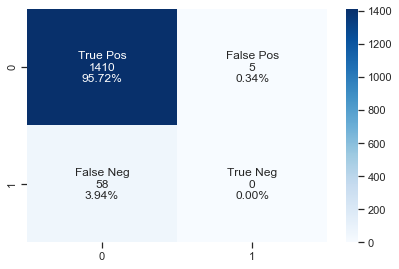

In [94]:
group_names = ['True Pos','False Pos','False Neg','True Neg']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [95]:
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_pred)
test_roc_auc = auc(test_fpr, test_tpr)

print('AUC for test set: %0.4f' % test_roc_auc)

AUC for test set: 0.4982


That's a very poor AUC, there is definitely rooom for improvement for this work. Future wotks: Try resampling data and extracting only the important features.